In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

In [2]:
test_data = pd.read_csv('./archive/exoTest.csv').fillna(0)
train_data = pd.read_csv('./archive/exoTrain.csv').fillna(0)

categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [3]:
#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


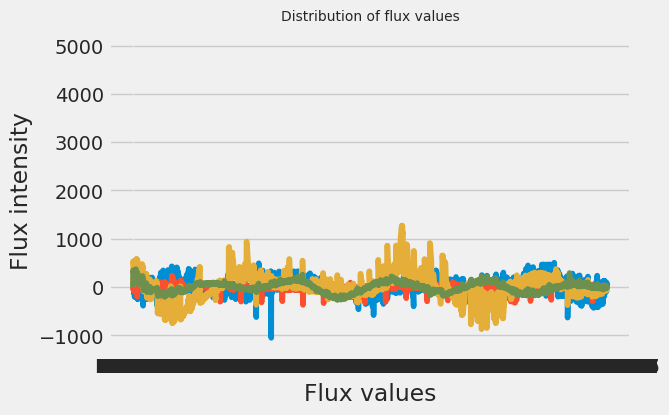

In [4]:
#Visualization:
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

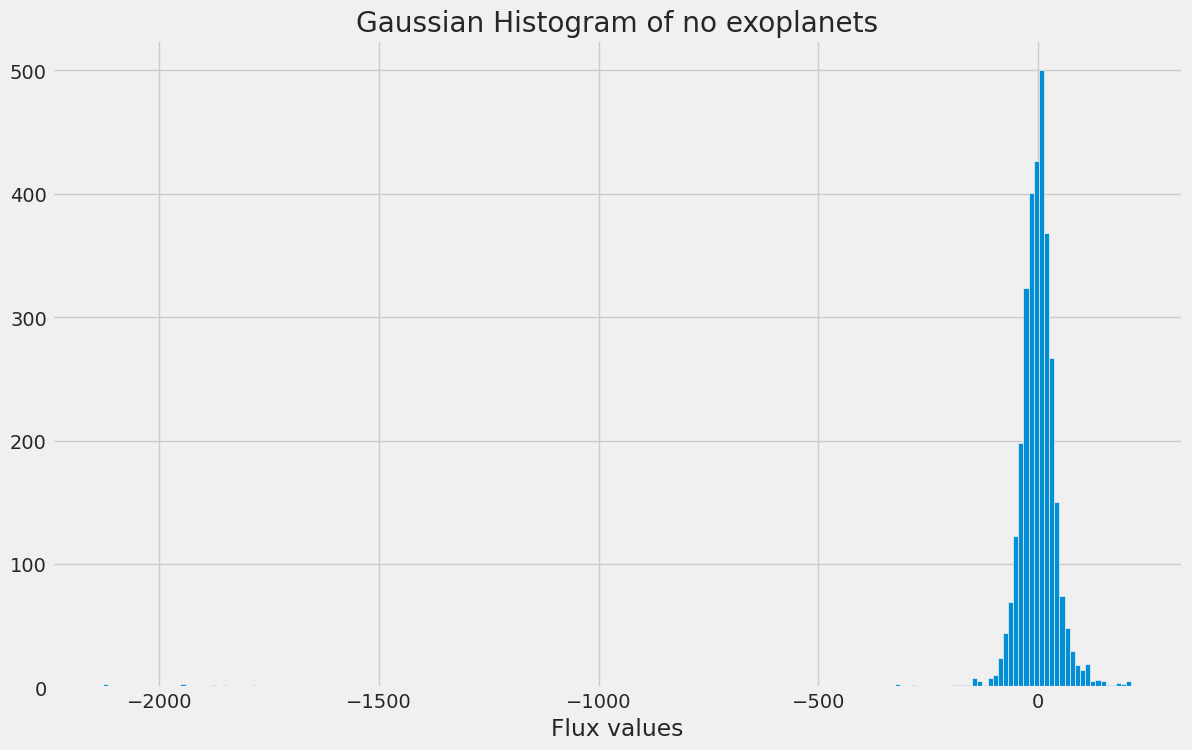

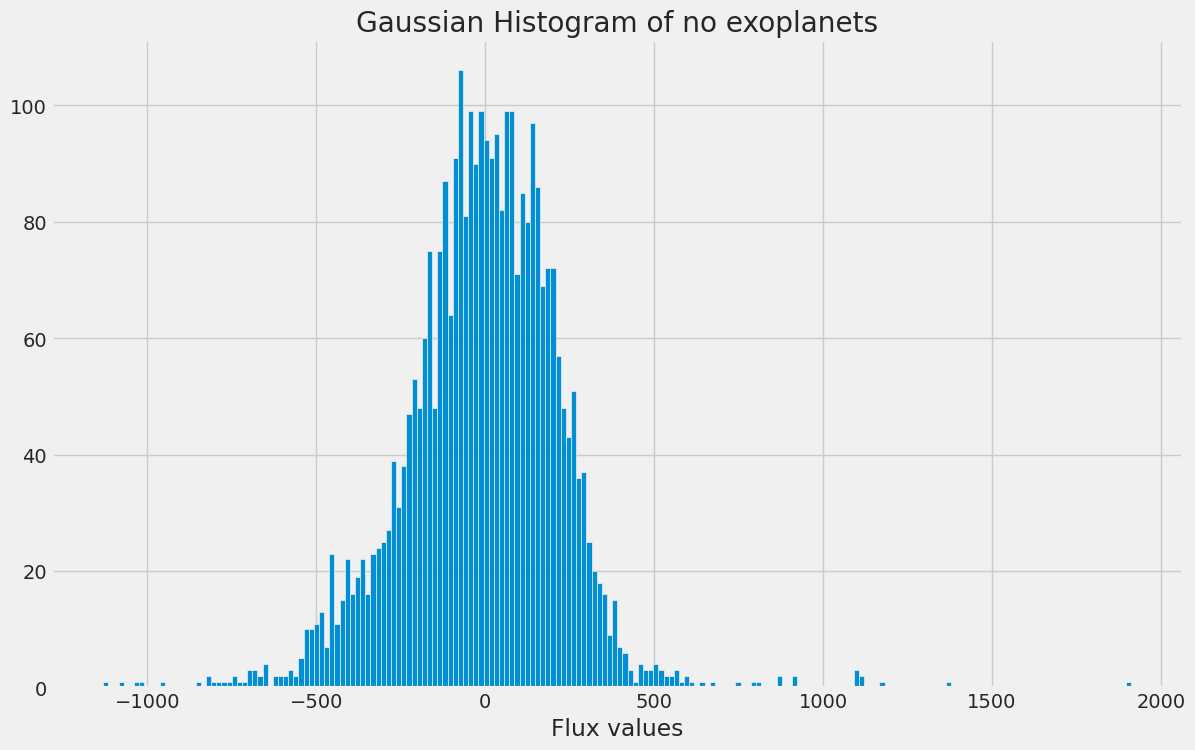

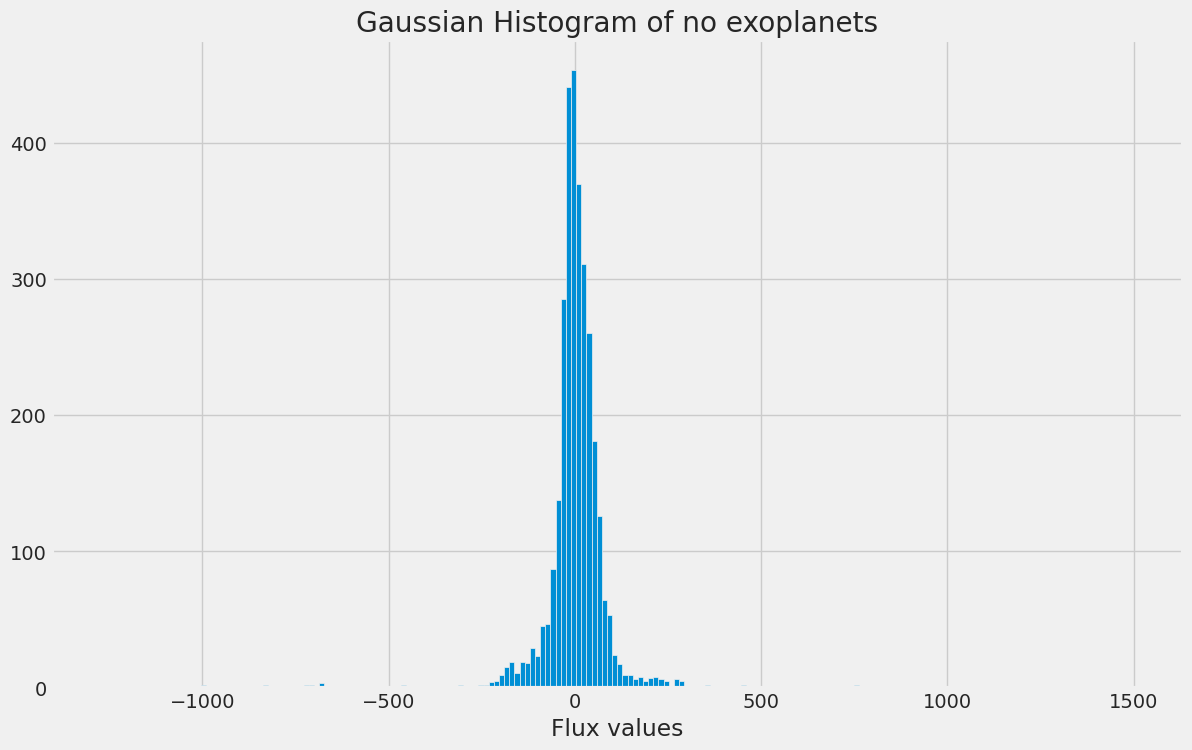

In [5]:
#Gaussian histogram of no exoplanets
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram of no exoplanets")
    plt.xlabel("Flux values")
    plt.show()

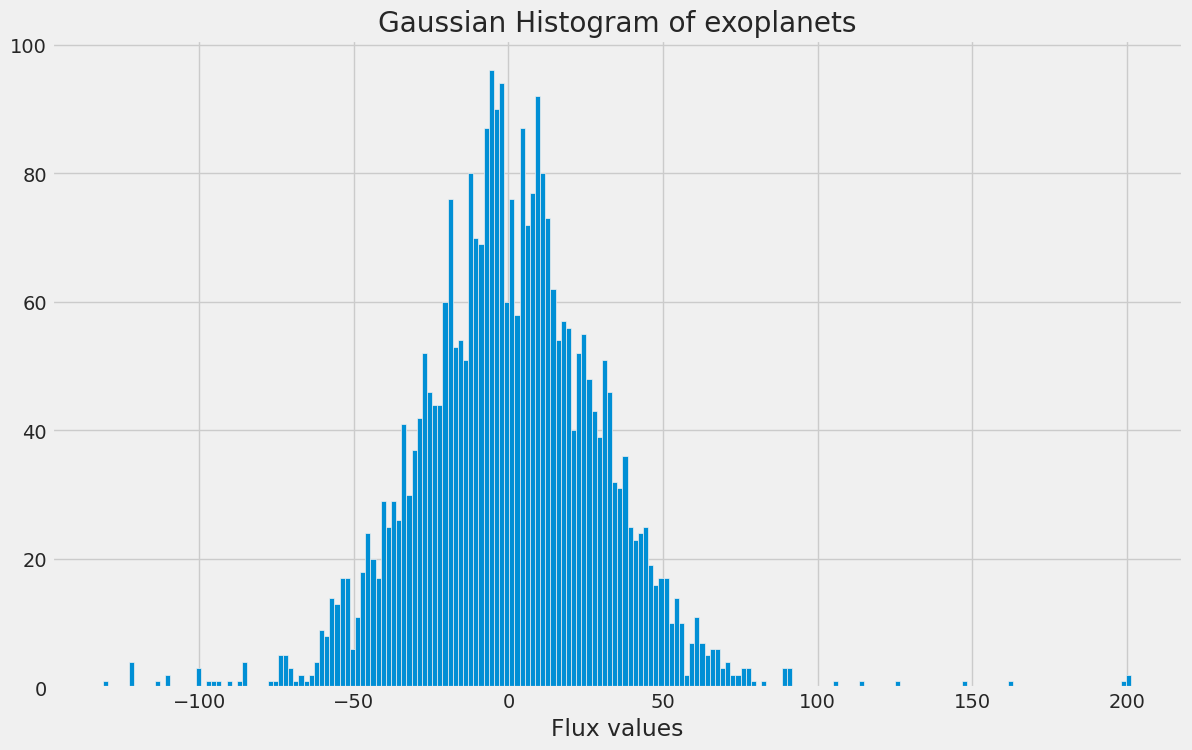

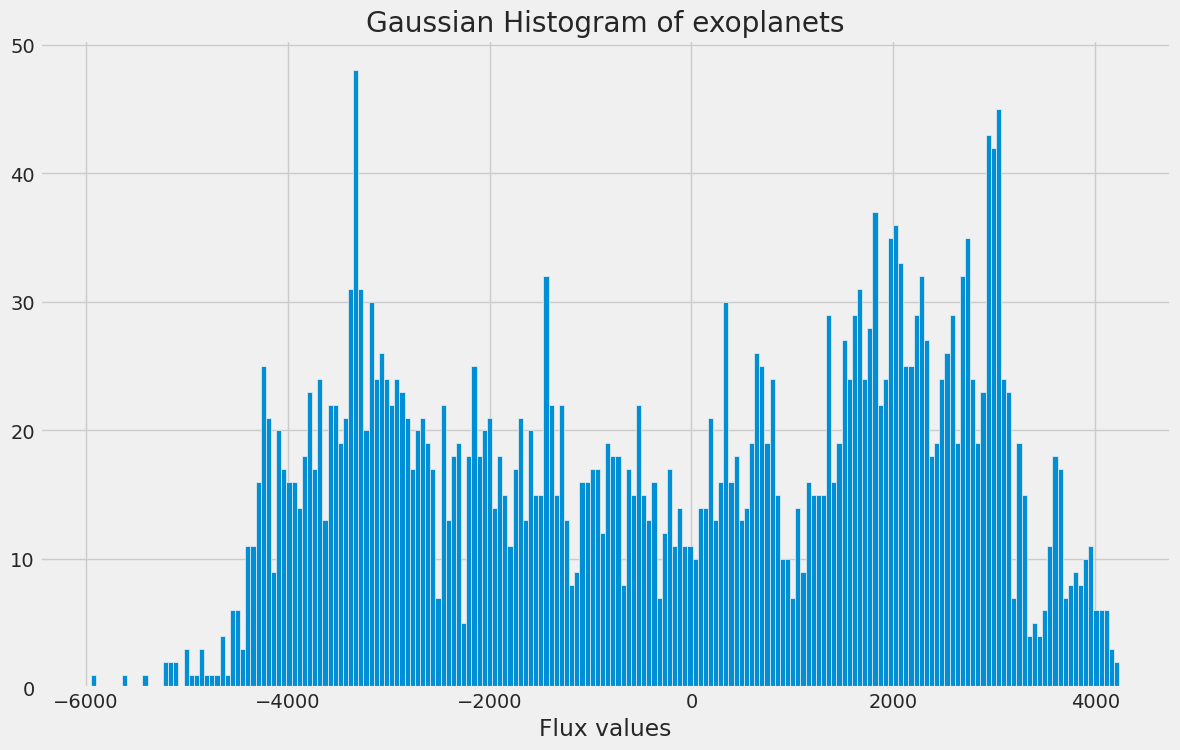

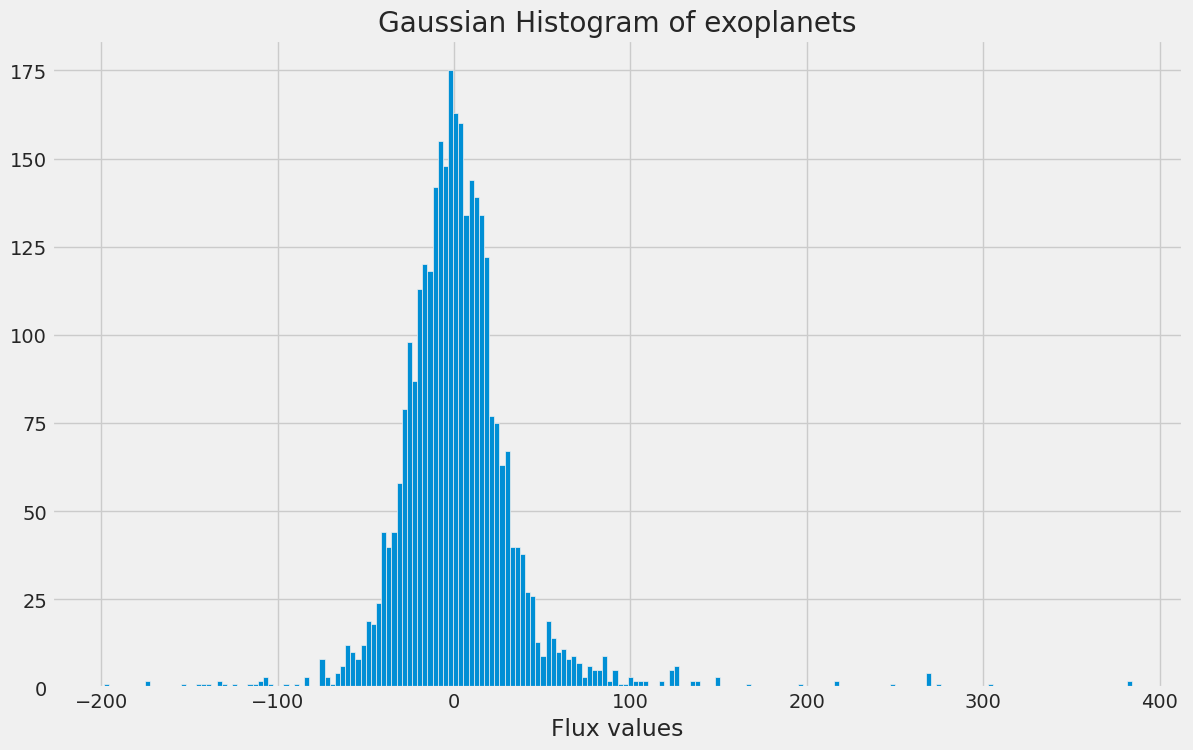

In [6]:
#Gaussian histogram of exoplanets
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram of exoplanets")
    plt.xlabel("Flux values")
    plt.show()

In [7]:
#splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

#Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)


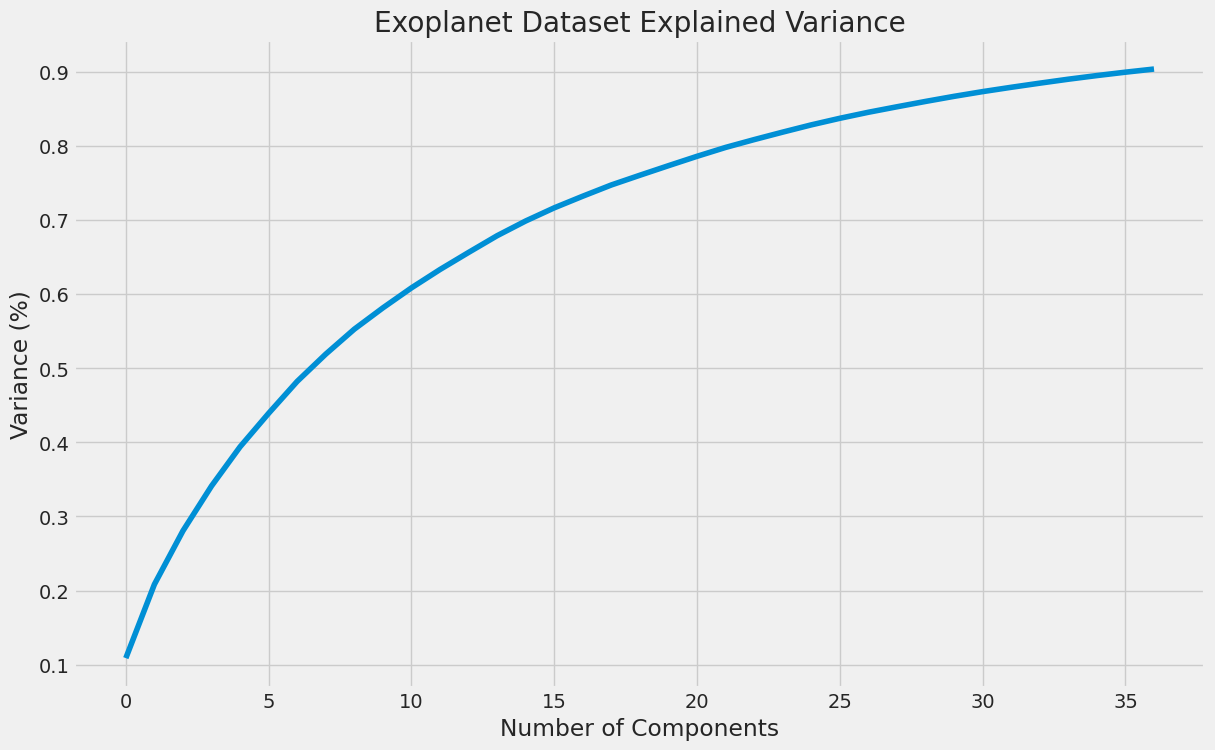

RangeIndex(start=0, stop=37, step=1)

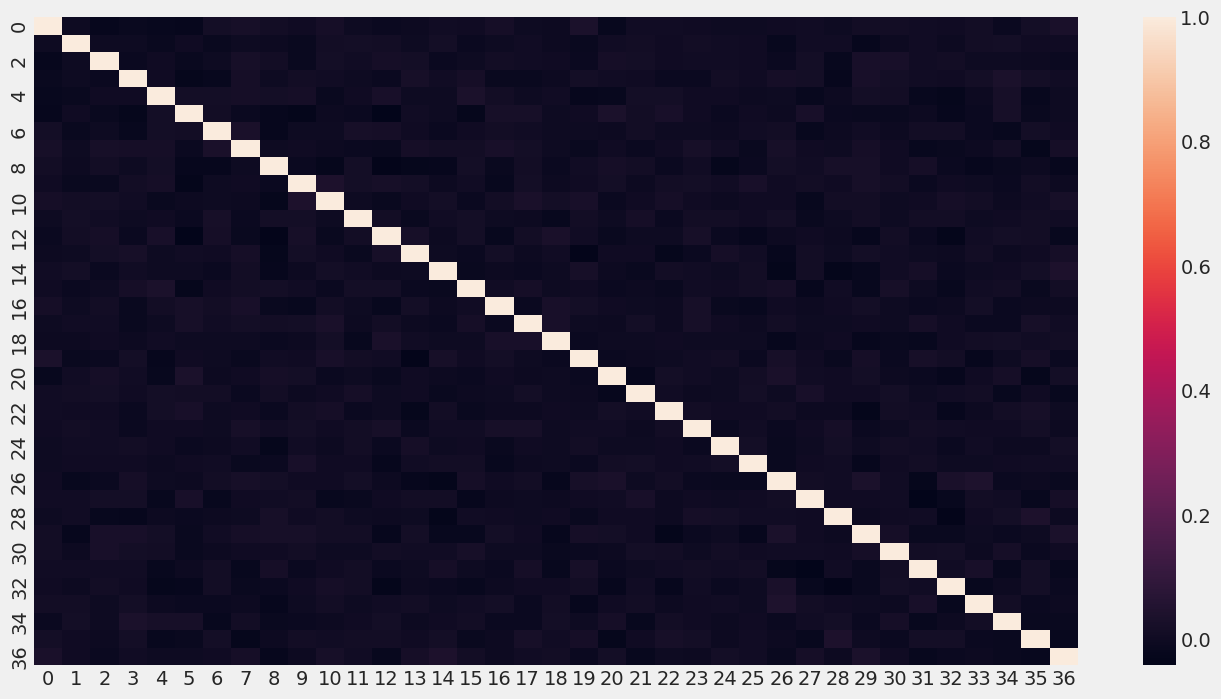

In [8]:
"""
This plot tells us that selecting 35 components we can preserve something around 98.8% or 99%
of the total variance of the data. It makes sense, we’ll not use 100% of our variance,
because it denotes all components, and we want only the principal ones.
"""
from sklearn.decomposition import PCA

#Apply PCA with n_componenets
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

df = pd.DataFrame.from_records(x_train)
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr)
df.columns

In [9]:
#Dimensionality reduction
pca = PCA()
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1


In [10]:
#Resampling as the data is highly unbalanced.
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=27, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


In [12]:
#Artificial Neural Network
import tensorflow
tensorflow.random.set_seed(101)
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

#Accuracy mean: 0.7791307791307792
#Accuracy variance: 0.26064381617895693

2025-05-23 17:09:11.874926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-23 17:09:12.053358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-23 17:09:12.053379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-05-23 17:09:12.073272: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 17:09:13.348197: W tensorflow/stream_executor/platform/de

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
253/253 [==============================] - 1s 3ms/step - loss: 0.4156 - accuracy: 0.9177
Epoch 2/40
253/253 [==============================] - 1s 3ms/step - loss: 0.5643 - accuracy: 0.8985
Epoch 2/40
253/253 [==============================] - 1s 2ms/step - loss: 0.1094 - accuracy: 0.9954
Epoch 3/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0625 - accuracy: 0.9837
Epoch 3/40
253/253 [==============================] - 1s 2ms/step - loss: 0.2418 - accuracy: 0.9552
Epoch 3/40
253/253 [==============================] - 1s 2ms/step - loss: 0.3370 - accuracy: 0.9933
Epoch 3/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0433 - accuracy: 0.9995
Epoch 4/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0048 - accuracy: 0.9999
Epoch 4/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0216 - accuracy: 0.9975
Epoch 4/40
253/253 [==============================] - 1s

2025-05-23 17:13:23.185984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-23 17:13:23.186015: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-23 17:13:23.186033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2025-05-23 17:13:23.186323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


18/18 [==============================] - 0s 687us/step
Validation accuracy of ANN is 0.9578947368421052

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       565
           1       0.00      0.00      0.00         5

    accuracy                           0.96       570
   macro avg       0.50      0.48      0.49       570
weighted avg       0.98      0.96      0.97       570



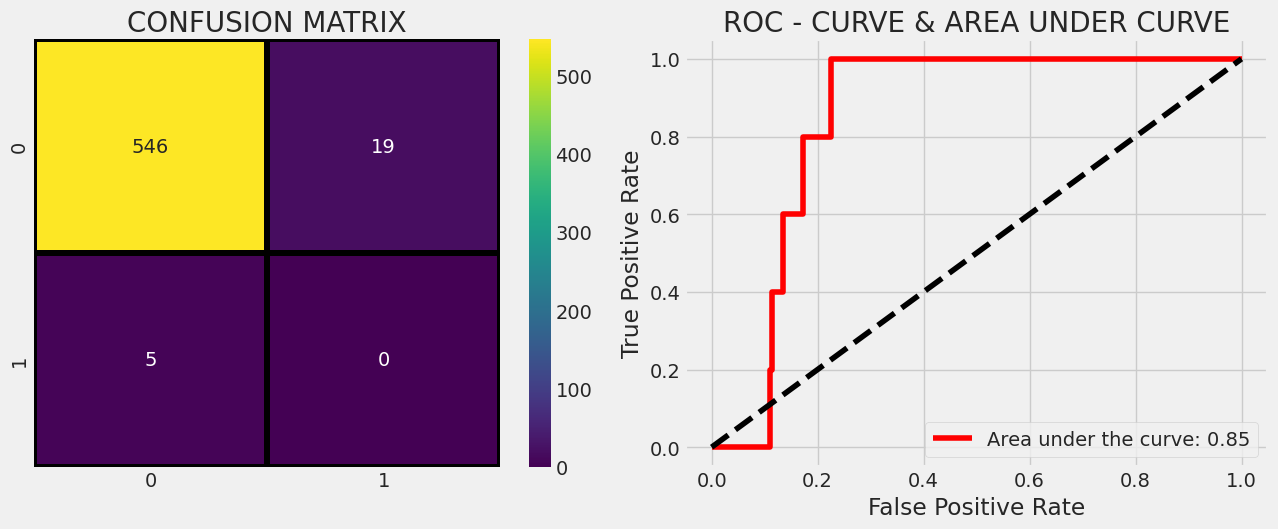

In [13]:
# Train the ANN on oversampled training data and evaluate on test set
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score

# Build and train the classifier
ann_model = Sequential()
ann_model.add(Dense(units=4, activation='relu', kernel_initializer='uniform', input_dim=x_train_res.shape[1]))
ann_model.add(Dense(units=4, activation='relu', kernel_initializer='uniform'))
ann_model.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann_model.fit(x_train_res, y_train_res, epochs=40, verbose=0)

# Predict and evaluate
y_pred_prob = ann_model.predict(x_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Print metrics
print("Validation accuracy of ANN is", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Plotting
plt.figure(figsize=(13,10))

# Confusion Matrix
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="viridis", fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area under the curve: {:.2f}".format(auc(fpr, tpr))), color="r")
plt.plot([0, 1], [0, 1], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)

plt.tight_layout()
plt.show()
